# Multi-Branch Networks (GoogLeNet)

In 2014, GoogLeNet won the ImageNet challenge, using a structure that combined the strengths of NiN (repeated blocks) with numerous different convolution kernels. It was the first network to make a clear distinction between the stem (data ingest) body (data processing) and head (output) in a CNN, which persists to this day. 

The major innovation is in the network body. While other approaches attempted to work out whether convolutions from 1x1 to 11x11 performed best, GoogLeNet instead concatenated multi-branch convolutions on all of these to determine which is best. 

In [1]:
import torch
from torch import nn
from d2l import torch as d2l
from torch.nn import functional as F

## Inception Blocks

The basic convolutional block of GoogLeNet is the _inception block_ from the meme in Inception about "needing to go deeper"

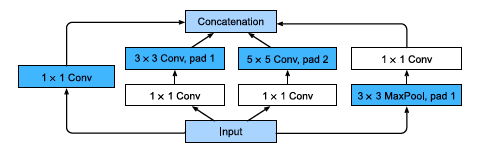

^ The Inception block, which consists of four parallel branches.

The first three branches use 1x1, 3x3 and 5x5 convolutions to extract low-level features with different spatial resolutions from the input image. The middle two branches also use 1x1 convolutions here to reduce the number of channels in the model to reduce the complexity. The fourth branch uses a 2x2 max pooling layer, followed by a 1x1 convolution to adjust the number of channels. All four branches use padding to keep the input and output dimensions of the block the same. In the final step, the outputs of the four branches are concatenated along the channel dimension, to produce the output. One of the commonly tuned hyperparameters is the number of output channels per branch - i.e. how much data "bandwidth" to allocate to convolutions of different sizes. 

One of the reasons GoogLeNet works so well, is that filters of different sizes can recognize features of different sizes in the image effectively. Different amounts of parameters can be allocated dynamically to the filters depending on how they are needed.

In [2]:
class Inception(nn.Module):
    def __init__(self, c1, c2, c3, c4, **kwargs):
        """
        c1 ... c4 are the number of output channels for the four branches 
        """

        # super(Inception, self).__init__(**kwargs)
        super().__init__(**kwargs)

        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)

        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)

        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)

        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)
        

## GoogLeNet Model

GoogLeNet uses a total of 9 of these incepton blocks, in three groups with max pooling between them which reduce the dimensionality. . The output is a global average pooling head. 

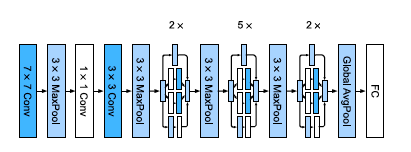

^ the GoogLeNet architecture

In [6]:
class GoogleNet(d2l.Classifier):

    def __init__(self, lr=0.1, num_classes=10):
        # super(GoogleNet, self).__init__()
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            self.b1(),
            self.b2(),
            self.b3(),
            self.b4(),
            self.b5(),
            nn.LazyLinear(num_classes)
        )

        self.net.apply(d2l.init_cnn)
    
    def b1(self):
        """ the first module uses a 64 channel 7x7 convolutional layer """
        return nn.Sequential(
            nn.LazyConv2d(out_channels=64, kernel_size=7, padding=3, stride=2),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

    def b2(self):
        """ The second module uses two layers, first a 1x1 convolution with 64 channels,
        then a 3x3 convolution that triples the number of channels to 192. """

        return nn.Sequential(
            nn.LazyConv2d(out_channels=64, kernel_size=1), nn.ReLU(),
            nn.LazyConv2d(out_channels=192, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

    def b3(self):
        """
        The third module connects two of our inception blocks in series. 
        We set the number of output channels of the first inception block to be 64 + 128 + 32 + 32 = 256, i.e. a ratio of 2:4:1:1. 
        We reduce the number of channels in the 1x1 convolutional layers to 96 and 16 respectively, 
        before increasing the number of channels during the spatially resolved convolutions. We then increase the number of 
        output channels again in the final output. 
        """
        return nn.Sequential(
            Inception(64, (96, 128), (16, 32), 32),
            Inception(128, (128, 192), (32, 96), 64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

    def b4(self):
        """
        Block four is more complciated, with 5 inception blocks concatenated with varying numbers of channels 
        512, 512, 512 and 528 channels for layers 1, 2, 3 and 4.
        The fifth and final block has 256 + 320 + 128 + 128 = 832 output channels.
        """
        return nn.Sequential(
            Inception(192, (96, 208), (16, 48), 64),
            Inception(160, (112, 224), (24, 64), 64),
            Inception(128, (128, 256), (24, 64), 64),
            Inception(112, (144, 288), (32, 64), 64),
            Inception(256, (160, 320), (32, 128), 128),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

    def b5(self):
        """
        The fifth block increases the number of channels to 832 and 1024 respectively. It then pools with the global average
        across each channel to produce our vector of logits/outputs. 
        """

        return nn.Sequential(
            Inception(256, (160, 320), (32, 128), 128),
            Inception(384, (192, 384), (48, 128), 128),
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten()
        )
                                

Obviously, the GoogLeNet architecture is fantastically complex compared to what we have so far encountered. In particular, there are a large number of seemingly arbitrary hyperparameters in the form of the number of channels of each of the blocks (and the individual inception blocks within these). 

In [7]:
model = GoogleNet().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


/Users/patrickrowe/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [8]:
model = GoogleNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(train=True)))[0]], d2l.init_cnn)

if torch.cuda.is_available():
    trainer.fit(model, data)
    
    # Save the parameters since this is expensive
    name = model.__class__.__name__ + "-" + data.__class__.__name__ + "-" + datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S') + ".pt"
    torch.save(model.state_dict(), name)
else: 
    print("You're not training this without a GPU. If you really wanna, you can remove this check")

You're not training this without a GPU. If you really wanna, you can remove this check


Surprisingly, despite the model complexity, GoogLeNet is actually CHEAPER to evaluate than its predecssors, while improving on accuracy. 